In [1]:
import csv
import math
from matplotlib import pyplot as plt
from matplotlib import figure
from tabulate import tabulate


methods = ['L2CS-Net', 'MCGaze', 'rt_gene']#, 'OpenFace']


def get_first_and_last_frame_by_calibration_point():

    first_and_last_frame_by_calibration_point = dict()
    
    # '../Step_3/' in the path seems unnecessary, but since MethodComparison.ipynb from
    # a different directory uses a copy of this function I preferred to adjust it here as well.
    # Then I can do changes in here and just copy functions over to MethodComparison.ipynb anew.
    with open('../Step_3/CalibrationFrames.csv') as csvfile:
        
        file_content = csv.DictReader(csvfile)

        for row in file_content:
            first_and_last_frame_by_calibration_point[int(row['calibration point'])] = {
                'first frame': int(row['first frame']),
                'last frame': int(row['last frame'])
            }

    return first_and_last_frame_by_calibration_point

def rad_to_deg(value_in_radians):
    return value_in_radians * 180 / math.pi

# There are multiple frames that belong to a specific calibration point
# (all frames between the first and last mouse click). Hence, this function
# returns a dictionary of lists where each list element is also a dictionary
# containing the estimated yaw and pitch angle.
def get_estimated_yaw_and_pitch_by_calibration_point(gaze_estimation_method):

    estimated_yaw_and_pitch_by_calibration_point = dict()
    first_and_last_frame_by_calibration_point = get_first_and_last_frame_by_calibration_point()

    # '../Step_3/' in the path seems unnecessary, but since MethodComparison.ipynb from
    # a different directory uses a copy of this function I preferred to adjust it here as well.
    # Then I can do changes in here and just copy functions over to MethodComparison.ipynb anew.
    with open('../Step_3/EstimatedGaze/' + gaze_estimation_method + '.csv') as csvfile:
        
        file_rows = list(csv.DictReader(csvfile))

        for calibration_point in first_and_last_frame_by_calibration_point:
            estimated_yaw_and_pitch_by_calibration_point[calibration_point] = []

            for frame_index in range(
                first_and_last_frame_by_calibration_point[calibration_point]['first frame'] - 1,
                first_and_last_frame_by_calibration_point[calibration_point]['last frame']
            ):
                estimated_yaw_and_pitch_by_calibration_point[calibration_point].append(
                    {
                        'yaw': rad_to_deg(float(file_rows[frame_index]['yaw in radians'])),
                        # in case of rt_gene I messed up the adjustment to OpenFace convention, hence need to negate pitch
                        'pitch': rad_to_deg(-float(file_rows[frame_index]['pitch in radians']) if (gaze_estimation_method == 'rt_gene') else float(file_rows[frame_index]['pitch in radians']))
                    }
                )

    return estimated_yaw_and_pitch_by_calibration_point


def print_estimated_yaw_and_pitch_by_calibration_point(estimated_yaw_and_pitch_by_calibration_point):

    for calibration_point in estimated_yaw_and_pitch_by_calibration_point:
        print('\nyaw and pitch for calibration point #' + str(calibration_point) + ':')

        for elem in estimated_yaw_and_pitch_by_calibration_point[calibration_point]:
            
            print('yaw: ' + str(elem['yaw']) + ', pitch: ' + str(elem['pitch']))

            
def plot_ground_truth_and_estimated_gaze(ground_truth_x_and_y_by_calibration_point, estimated_yaw_and_pitch_by_calibration_point):
    
    plt.rcParams["figure.figsize"] = (5,5)

    #
    # First: Plot ground truth of x coordinate on screen against estimated yaw gaze angle
    #

    x_axis_values = []
    y_axis_values = []

    for calibration_point in estimated_yaw_and_pitch_by_calibration_point:

        for elem in estimated_yaw_and_pitch_by_calibration_point[calibration_point]:
            x_axis_values.append(ground_truth_x_and_y_by_calibration_point[calibration_point]['x'])
            y_axis_values.append(elem['yaw'])

    plt.scatter(x_axis_values, y_axis_values)
    plt.xlabel('ground truth x coordinate on screen')
    plt.ylabel('estimated yaw gaze angle during mouse clicks')
    plt.show()

    #
    # Next: Plot ground truth of x coordinate on screen against estimated yaw gaze angle
    #

    x_axis_values = []
    y_axis_values = []

    for calibration_point in estimated_yaw_and_pitch_by_calibration_point:

        for elem in estimated_yaw_and_pitch_by_calibration_point[calibration_point]:
            x_axis_values.append(ground_truth_x_and_y_by_calibration_point[calibration_point]['y'])
            y_axis_values.append(elem['pitch'])

    plt.scatter(x_axis_values, y_axis_values)
    plt.xlabel('ground truth y coordinate on screen')
    plt.ylabel('estimated pitch gaze angle during mouse clicks')
    plt.show()


def calculate_mean_of_estimated_yaw_and_pitch_by_calibration_point(estimated_yaw_and_pitch_by_calibration_point):
    
    mean_of_estimated_yaw_and_pitch_by_calibration_point = dict()

    for calibration_point in estimated_yaw_and_pitch_by_calibration_point:
        sum_yaw = 0.0
        sum_pitch = 0.0
        count_non_nan = 0

        for elem in estimated_yaw_and_pitch_by_calibration_point[calibration_point]:
            # if one of yaw and pitch is nan then the other is too
            if not math.isnan(elem['yaw']):
                sum_yaw += elem['yaw']
                sum_pitch += elem['pitch']
                count_non_nan += 1

        mean_of_estimated_yaw_and_pitch_by_calibration_point[calibration_point] = {
            'yaw': round(sum_yaw / count_non_nan, 3),
            'pitch': round(sum_pitch / count_non_nan, 3)
            }
        
    return mean_of_estimated_yaw_and_pitch_by_calibration_point


def print_mean_of_estimated_yaw_and_pitch_by_calibration_point(
    mean_of_estimated_yaw_and_pitch_by_calibration_point,
    calibration_point_name_by_calibration_point
):
    
    for calibration_point in mean_of_estimated_yaw_and_pitch_by_calibration_point:
        print('\nmean for calibration point #' + str(calibration_point) + ' (' +
              calibration_point_name_by_calibration_point[calibration_point] + '):')
        print(
            'yaw: ' + str(mean_of_estimated_yaw_and_pitch_by_calibration_point[calibration_point]['yaw']) + ', '
            'pitch: ' + str(mean_of_estimated_yaw_and_pitch_by_calibration_point[calibration_point]['pitch'])
            )

        

# In the video he looks 1. top left 2. top right 3. center 4. bottom left 5. bottom right.
# The values from the .json data from the SIT calibration were sorted into the dict below accordingly.
ground_truth_x_and_y_by_calibration_point = {
    1: { 'x': 40.953125, 'y': 40.953125 },
    2: { 'x': 1977.046875, 'y': 40.953125 },
    3: { 'x': 1024, 'y': 640 },
    4: { 'x': 40.953125, 'y': 1209.046875 },
    5: { 'x': 1977.046875, 'y': 1209.046875 }
}

calibration_point_name_by_calibration_point = {
    1: 'top left',
    2: 'top right',
    3: 'center',
    4: 'bottom left',
    5: 'bottom right'
}


top_left_VS_bottom_left = []
top_right_VS_bottom_right = []
avg_same_x_coordinate = []

top_left_VS_top_right = []
bottom_left_VS_bottom_right = []
avg_same_y_coordinate = []

avg_same_x_or_y_coordinate = []

for i, method in enumerate(methods):

    estimated_yaw_and_pitch_by_calibration_point = get_estimated_yaw_and_pitch_by_calibration_point(method)
    #print_estimated_yaw_and_pitch_by_calibration_point(estimated_yaw_and_pitch_by_calibration_point)

    #plot_ground_truth_and_estimated_gaze(ground_truth_x_and_y_by_calibration_point, estimated_yaw_and_pitch_by_calibration_point)

    print('\n\n### ' + method + ' ###')
    mean_of_estimated_yaw_and_pitch_by_calibration_point = calculate_mean_of_estimated_yaw_and_pitch_by_calibration_point(estimated_yaw_and_pitch_by_calibration_point)
    print_mean_of_estimated_yaw_and_pitch_by_calibration_point(mean_of_estimated_yaw_and_pitch_by_calibration_point, calibration_point_name_by_calibration_point)
 
    top_left_VS_bottom_left.append(str(abs(round(mean_of_estimated_yaw_and_pitch_by_calibration_point[1]['yaw'] - mean_of_estimated_yaw_and_pitch_by_calibration_point[4]['yaw'], 3))))
    top_right_VS_bottom_right.append(str(abs(round(mean_of_estimated_yaw_and_pitch_by_calibration_point[2]['yaw'] - mean_of_estimated_yaw_and_pitch_by_calibration_point[5]['yaw'], 3))))
    avg_same_x_coordinate.append(round( (float(top_left_VS_bottom_left[i]) + float(top_right_VS_bottom_right[i])) / 2, 3))
    
    top_left_VS_top_right.append(str(abs(round(mean_of_estimated_yaw_and_pitch_by_calibration_point[1]['pitch'] - mean_of_estimated_yaw_and_pitch_by_calibration_point[2]['pitch'], 3))))
    bottom_left_VS_bottom_right.append(str(abs(round(mean_of_estimated_yaw_and_pitch_by_calibration_point[4]['pitch'] - mean_of_estimated_yaw_and_pitch_by_calibration_point[5]['pitch'], 3))))
    avg_same_y_coordinate.append(round( (float(top_left_VS_top_right[i]) + float(bottom_left_VS_bottom_right[i])) / 2, 3))
    
    avg_same_x_or_y_coordinate.append(round(
        (float(top_left_VS_bottom_left[i]) + float(top_right_VS_bottom_right[i]) + float(top_left_VS_top_right[i]) + float(bottom_left_VS_bottom_right[i])) / 4,
        3
    ))
    
    
    
print(
    '\n\nAbsolute differences between mean gaze angle of calibration points that have the same\n'
    'ground truth for x resp. y coordinate on screen:\n' +
    tabulate(
    [
        ['top left vs. bottom left (same x coordinate)'] + top_left_VS_bottom_left,
        ['top right vs. bottom right (same x coordinate)'] + top_right_VS_bottom_right,
        ['average (same x coordinate)'] + avg_same_x_coordinate,
        ['top left vs. top right (same y coordinate)'] + top_left_VS_top_right,
        ['bottom left vs. bottom right (same y coordinate)'] + bottom_left_VS_bottom_right,
        ['average (same y coordinate)'] + avg_same_y_coordinate,
        ['total average (same x or y coordinate)'] + avg_same_x_or_y_coordinate
    ],
    headers=[''] + methods,
    tablefmt='fancy_grid'
))



### L2CS-Net ###

mean for calibration point #1 (top left):
yaw: 11.352, pitch: -1.602

mean for calibration point #2 (top right):
yaw: -8.152, pitch: -3.099

mean for calibration point #3 (center):
yaw: 0.857, pitch: 3.202

mean for calibration point #4 (bottom left):
yaw: 11.338, pitch: 11.933

mean for calibration point #5 (bottom right):
yaw: -11.134, pitch: 18.239


### MCGaze ###

mean for calibration point #1 (top left):
yaw: 21.983, pitch: -8.613

mean for calibration point #2 (top right):
yaw: -3.618, pitch: -8.66

mean for calibration point #3 (center):
yaw: 5.983, pitch: -0.966

mean for calibration point #4 (bottom left):
yaw: 16.444, pitch: 6.836

mean for calibration point #5 (bottom right):
yaw: -6.574, pitch: 12.597


### rt_gene ###

mean for calibration point #1 (top left):
yaw: 3.167, pitch: 2.993

mean for calibration point #2 (top right):
yaw: -11.531, pitch: 7.059

mean for calibration point #3 (center):
yaw: -6.438, pitch: 11.224

mean for calibration point #4 



color of point in plot indicates which calibration point it belongs to:
top left in green
top right in blue
center in red
bottom left in orange
bottom right in magenta


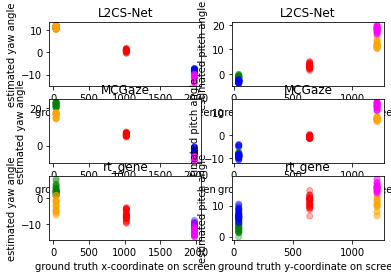

In [2]:
#
# NOTE:
# For some reason this code needs to be executed a second time until
# the plot is shown in the right size.
#


def plot_all_methods(ground_truth_x_and_y_by_calibration_point):
    
    plt.rcParams["figure.figsize"] = (15, 20)#(12,15)
    
    plot_number = 1
    
    color_by_calibration_point = {
        1: 'green',
        2: 'blue',
        3: 'red',
        4: 'orange',
        5: 'magenta'
    }
    
    print('\n\ncolor of point in plot indicates which calibration point it belongs to:')
    for calibration_point in range(1, 5+1):
        print(
            '\033[1m' +
            calibration_point_name_by_calibration_point[calibration_point] + ' in ' +
            color_by_calibration_point[calibration_point] + '\033[0m'
        )
    
    
    # Plot estimated gaze angles during calibration mouse clicks. Can't set this with
    # plt.suptitle(), because there's too much vertical space between title and plot.
    for method_index, method in enumerate(methods):
        
        estimated_yaw_and_pitch_by_calibration_point = get_estimated_yaw_and_pitch_by_calibration_point(method)
        plot_colors = []
        
        #
        # First: Plot ground truth of x coordinate on screen against estimated yaw gaze angle
        #

        x_axis_values = []
        y_axis_values = []

        for calibration_point in estimated_yaw_and_pitch_by_calibration_point:

            for elem in estimated_yaw_and_pitch_by_calibration_point[calibration_point]:
                x_axis_values.append(ground_truth_x_and_y_by_calibration_point[calibration_point]['x'])
                y_axis_values.append(elem['yaw'])
                plot_colors.append(color_by_calibration_point[calibration_point])
        
        plt.subplot(len(methods), 2, 1 + 2*method_index)
        plt.title(method)
        plt.scatter(x_axis_values, y_axis_values, c=plot_colors, alpha=0.3)
        #ax = plt.gca()
        #ax.set_ylim([-0.3, 0.45])
        plt.xlabel("ground truth x-coordinate on screen")
        plt.ylabel("estimated yaw angle")

        #
        # Next: Plot ground truth of y coordinate on screen against estimated pitch gaze angle
        #

        x_axis_values = []
        y_axis_values = []

        for calibration_point in estimated_yaw_and_pitch_by_calibration_point:

            for elem in estimated_yaw_and_pitch_by_calibration_point[calibration_point]:
                x_axis_values.append(ground_truth_x_and_y_by_calibration_point[calibration_point]['y'])
                y_axis_values.append(elem['pitch'])
                
        plt.subplot(len(methods), 2, 1 + 2*method_index+1)
        plt.title(method)
        plt.scatter(x_axis_values, y_axis_values, color=plot_colors, alpha=0.3)
        #ax = plt.gca()
        #ax.set_ylim([-0.2, 0.4])
        plt.xlabel("ground truth y-coordinate on screen")
        plt.ylabel("estimated pitch angle")

        
        plot_number += 1
    
    
    plt.show()
    
    
     
plot_all_methods(ground_truth_x_and_y_by_calibration_point)

In [3]:
from statistics import mean
import numpy as np


def two_norm(yaw, pitch):
    return math.sqrt(pow(yaw, 2) + pow(pitch, 2))

def calculate_distances_to_calibration_point_means(
    estimated_yaw_and_pitch_by_calibration_point,
    mean_of_estimated_yaw_and_pitch_by_calibration_point
):
    
    distances_to_calibration_point_means = dict()
    
    for calibration_point in estimated_yaw_and_pitch_by_calibration_point:
        
        distances_to_calibration_point_means[calibration_point] = []
        
        for elem in estimated_yaw_and_pitch_by_calibration_point[calibration_point]:
            
            # if yaw is nan then pitch is nan as well
            if not math.isnan(elem['yaw']):
                distances_to_calibration_point_means[calibration_point].append(
                    two_norm(
                        elem['yaw'] - mean_of_estimated_yaw_and_pitch_by_calibration_point[calibration_point]['yaw'],
                        elem['pitch'] - mean_of_estimated_yaw_and_pitch_by_calibration_point[calibration_point]['pitch']
                    )
                )
                
    return distances_to_calibration_point_means

def calculate_abs_yaw_and_pitch_differences_to_calibration_point_means(
    estimated_yaw_and_pitch_by_calibration_point,
    mean_of_estimated_yaw_and_pitch_by_calibration_point
):
    
    abs_yaw_differences_to_calibration_point_means = dict()
    abs_pitch_differences_to_calibration_point_means = dict()
    
    for calibration_point in estimated_yaw_and_pitch_by_calibration_point:
        
        abs_yaw_differences_to_calibration_point_means[calibration_point] = []
        abs_pitch_differences_to_calibration_point_means[calibration_point] = []
        
        for elem in estimated_yaw_and_pitch_by_calibration_point[calibration_point]:
            
            # if yaw is nan then pitch is nan as well
            if not math.isnan(elem['yaw']):
                
                abs_yaw_differences_to_calibration_point_means[calibration_point].append(
                    abs(elem['yaw'] - mean_of_estimated_yaw_and_pitch_by_calibration_point[calibration_point]['yaw']),
                )
                
                abs_pitch_differences_to_calibration_point_means[calibration_point].append(
                    abs(elem['pitch'] - mean_of_estimated_yaw_and_pitch_by_calibration_point[calibration_point]['pitch'])
                )
                
    return abs_yaw_differences_to_calibration_point_means, abs_pitch_differences_to_calibration_point_means
    

    
for method in methods:

    estimated_yaw_and_pitch_by_calibration_point = get_estimated_yaw_and_pitch_by_calibration_point(method)
    
    mean_of_estimated_yaw_and_pitch_by_calibration_point = calculate_mean_of_estimated_yaw_and_pitch_by_calibration_point(estimated_yaw_and_pitch_by_calibration_point)
    
    distances_to_calibration_point_means = calculate_distances_to_calibration_point_means(
        estimated_yaw_and_pitch_by_calibration_point,
        mean_of_estimated_yaw_and_pitch_by_calibration_point
    )    
    
    abs_yaw_differences_to_calibration_point_means, abs_pitch_differences_to_calibration_point_means = calculate_abs_yaw_and_pitch_differences_to_calibration_point_means(
        estimated_yaw_and_pitch_by_calibration_point,
        mean_of_estimated_yaw_and_pitch_by_calibration_point
    )
    
    
    count_gaze_estimations_for_all_calibration_points_combined = 0
    
    for cp in distances_to_calibration_point_means:
        count_gaze_estimations_for_all_calibration_points_combined += len(distances_to_calibration_point_means[cp])
    
    mean_distances_to_calibration_point_means = []
    max_distances_to_calibration_point_means = []
    mean_abs_yaw_differences_to_calibration_point_means = []
    max_abs_yaw_differences_to_calibration_point_means = []
    mean_abs_pitch_differences_to_calibration_point_means = []
    max_abs_pitch_differences_to_calibration_point_means = []
    
    
    for calibration_point in distances_to_calibration_point_means:
        mean_distances_to_calibration_point_means.append(round(mean(distances_to_calibration_point_means[calibration_point]), 2))
        max_distances_to_calibration_point_means.append(round(max(distances_to_calibration_point_means[calibration_point]), 2))
        mean_abs_yaw_differences_to_calibration_point_means.append(round(mean(abs_yaw_differences_to_calibration_point_means[calibration_point]), 2))
        max_abs_yaw_differences_to_calibration_point_means.append(round(max(abs_yaw_differences_to_calibration_point_means[calibration_point]), 2))
        mean_abs_pitch_differences_to_calibration_point_means.append(round(mean(abs_pitch_differences_to_calibration_point_means[calibration_point]), 2))
        max_abs_pitch_differences_to_calibration_point_means.append(round(max(abs_pitch_differences_to_calibration_point_means[calibration_point]), 2))
        
        
    print('\n\n### ' + method + ' ###')
    
    abs_yaw_diffs = []
    abs_pitch_diffs = []
    
    for cp in abs_yaw_differences_to_calibration_point_means:
        for abs_yaw_diff in abs_yaw_differences_to_calibration_point_means[cp]:
            abs_yaw_diffs.append(abs_yaw_diff)
    
    for cp in abs_pitch_differences_to_calibration_point_means:
        for abs_pitch_diff in abs_pitch_differences_to_calibration_point_means[cp]:
            abs_pitch_diffs.append(abs_pitch_diff)
    
    
    print('\nTable values refer to differences resp. distances to the gaze estimation mean of corresponding calibration point:')
    
    print(
        tabulate(
            [
                ['mean abs yaw angle diff'] + mean_abs_yaw_differences_to_calibration_point_means,
                ['mean abs pitch angle diff'] + mean_abs_pitch_differences_to_calibration_point_means,
                ['max abs yaw angle diff'] + max_abs_yaw_differences_to_calibration_point_means,
                ['max abs pitch angle diff'] + max_abs_pitch_differences_to_calibration_point_means,
                ['mean euclidean distance'] + mean_distances_to_calibration_point_means,
                ['max euclidean distance'] + max_distances_to_calibration_point_means
            ],
            headers=['', 'top left', 'top right', 'center', 'bottom left', 'bottom right'],
            tablefmt='fancy_grid'
        )
    )
    
    print(
        tabulate(
            [
                ['abs yaw angle diff'] + [str(round(mean(mean_abs_yaw_differences_to_calibration_point_means), 2)), str(round(max(max_abs_yaw_differences_to_calibration_point_means), 2)), round(np.mean(abs_yaw_diffs) + 4.0*np.std(abs_yaw_diffs), 2)],
                ['abs pitch angle diff'] + [str(round(mean(mean_abs_pitch_differences_to_calibration_point_means), 2)), str(round(max(max_abs_pitch_differences_to_calibration_point_means), 2)), round(np.mean(abs_pitch_diffs) + 4.0*np.std(abs_pitch_diffs), 2)],
                ['euclidean distance'] + [str(round(mean(mean_distances_to_calibration_point_means), 2)), str(round(max(max_distances_to_calibration_point_means), 2)), ]
            ],
            headers=['', 'mean of means', 'max of all calibration points', '\N{greek small letter mu} + 4*\N{greek small letter sigma}'],
            tablefmt='fancy_grid'
        )
    )




### L2CS-Net ###

Table values refer to differences resp. distances to the gaze estimation mean of corresponding calibration point:
╒═══════════════════════════╤════════════╤═════════════╤══════════╤═══════════════╤════════════════╕
│                           │   top left │   top right │   center │   bottom left │   bottom right │
╞═══════════════════════════╪════════════╪═════════════╪══════════╪═══════════════╪════════════════╡
│ mean abs yaw angle diff   │       0.44 │        0.31 │     0.43 │          0.47 │           0.81 │
├───────────────────────────┼────────────┼─────────────┼──────────┼───────────────┼────────────────┤
│ mean abs pitch angle diff │       0.6  │        0.37 │     0.69 │          0.89 │           0.89 │
├───────────────────────────┼────────────┼─────────────┼──────────┼───────────────┼────────────────┤
│ max abs yaw angle diff    │       0.97 │        0.99 │     1.26 │          0.92 │           2.85 │
├───────────────────────────┼────────────┼─────────────┼──